# Installations 

In [1]:
!pip install -q transformers datasets
!pip install -q pyyaml==5.4.1

     |████████████████████████████████| 4.4 MB 30.9 MB/s 
     |████████████████████████████████| 362 kB 68.7 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
     |████████████████████████████████| 596 kB 23.4 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 1.1 MB 58.0 MB/s 
     |████████████████████████████████| 212 kB 78.9 MB/s 
     |████████████████████████████████| 140 kB 77.4 MB/s 
     |████████████████████████████████| 127 kB 67.7 MB/s 
     |████████████████████████████████| 271 kB 74.1 MB/s 
     |████████████████████████████████| 144 kB 62.2 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████|

# Imports 

In [2]:
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import plotly.express as px
from datasets import Dataset
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm, trange
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder,  LabelBinarizer
from transformers import Trainer, TrainingArguments,  AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix , classification_report 



import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# Data Loading and Config Setup

In [4]:
train = pd.read_excel("/content/Training.xlsx")
train.rename(columns = {"Category":"label"}, inplace = True)

counts = train["label"].value_counts().reset_index()
counts = counts.sort_values(by = "index")
counts["index"] = counts["index"].astype("str")
CLASS_LABELS = counts["index"].to_list()


class config:   #If you wish to play with some parameters, just change them in config class here
    MODEL_NAME = "ProsusAI/finbert"
    TOKENIZER_NAME = "ProsusAI/finbert"
    LOWER_CASE = True
    MAX_LEN = 32
    RANDOM_STATE = 12
    TEST_SIZE = 0.2
    NUM_LABELS = 10
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-5
    EPOCHS = 5
    WEIGTH_DECAY = 0.001
    DEVICE = "cuda"

# EDA 

In [5]:
fig = px.bar(
    data_frame= counts,
    x = "index",
    y = "label" , 
    color = "label" ,
    color_continuous_scale="Emrld") 
fig.update_xaxes(title="Labels")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})             

#the output here gives us the data distribution i.e the number of transactions 
#belonging to each categories

In [6]:
train["Words per description"] = train["trans_desc"].str.split().apply(len)
hist = px.histogram(data_frame=train,
             x = "Words per description", 
             color = "label", 
             nbins =  50) 

hist.update_layout(showlegend = True,
    title = {
        'text': 'Word Count Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
hist.show()

#the output here shows us the word count distribution i.e the frequency of the words per description

# Data Processing and Tokenization 

In [7]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME, do_lower_case = config.LOWER_CASE)
def tokenize(batch):
    return tokenizer(batch["trans_desc"], max_length = config.MAX_LEN, padding=True, truncation=True)

encoder = LabelEncoder()
train["label"] = encoder.fit_transform(train["label"])


dataset = Dataset.from_pandas(train[["trans_desc", "label"]])
dataset = dataset.train_test_split(test_size = config.TEST_SIZE, seed = config.RANDOM_STATE )
dataset = dataset.map(tokenize,remove_columns=['trans_desc'])

#The tokenizer and model weights were obtained from the HuggingFace library. 
#Huggingface library is an open-source library that provides weights for a variety of pretrained transformers.

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Parameter 'function'=<function tokenize at 0x7ff1a43fc8c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/32000 [00:00<?, ?ex/s]

  0%|          | 0/8000 [00:00<?, ?ex/s]

# Modelling 

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(config.MODEL_NAME, 
                                                           num_labels=config.NUM_LABELS, 
                                                           ignore_mismatched_sizes=True)
model = model.to(config.DEVICE)

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training Utilities 

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"Accuracy": acc,
            "Precision": precision, 
            "Recall":recall, 
            "F1 Score": f1}


## trainning areguments
logging_steps = len(dataset["train"]) // config.BATCH_SIZE
training_args = TrainingArguments(output_dir=config.MODEL_NAME,
                                  num_train_epochs=config.EPOCHS,
                                  learning_rate=config.LEARNING_RATE,
                                  per_device_train_batch_size=config.BATCH_SIZE,
                                  per_device_eval_batch_size=config.BATCH_SIZE,
                                  weight_decay=config.WEIGTH_DECAY,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps)

# Training 

In [10]:
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset["train"],
                  eval_dataset=dataset["test"],
                  tokenizer=tokenizer)
trainer.train();

# FinBERT was trained on training data. AdamW optimizer with a learning rate of 0.00002 was used and the model was trained for 5 epochs. 
#The model was evaluated on the validation set with a variety of classification metrics. 
#The metrics included accuracy, precision, recall, f1 score, and AUC roc score.
#Training for a total of 5 epochs on a batch size of 32

***** Running training *****
  Num examples = 32000
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5000


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score
1,1.359400,1.037475,0.653250,0.638678,0.653250,0.642252
2,0.986700,0.965028,0.678000,0.667877,0.678000,0.666560
3,0.868200,0.937938,0.690250,0.686411,0.690250,0.683566
4,0.789600,0.945258,0.692375,0.686875,0.692375,0.685439
5,0.743700,0.955284,0.690125,0.685003,0.690125,0.685542


Saving model checkpoint to ProsusAI/finbert/checkpoint-500
Configuration saved in ProsusAI/finbert/checkpoint-500/config.json
Model weights saved in ProsusAI/finbert/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ProsusAI/finbert/checkpoint-500/tokenizer_config.json
Special tokens file saved in ProsusAI/finbert/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ProsusAI/finbert/checkpoint-1000
Configuration saved in ProsusAI/finbert/checkpoint-1000/config.json
Model weights saved in ProsusAI/finbert/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ProsusAI/finbert/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ProsusAI/finbert/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 8000
  Batch size = 32
Saving model checkpoint to ProsusAI/finbert/checkpoint-1500
Configuration saved in ProsusAI/finbert/checkpoint-1500/config.json
Model weights saved in ProsusAI/finbert/checkpoint-1500/py

# Model Evaluation 

In [11]:
y_test = dataset["test"]["label"]
preds = trainer.predict(dataset["test"])
metrics = preds.metrics
preds = preds.predictions
y_preds = np.argmax(preds , axis = 1 )
print("Differnt Classification Metrics score on test data:")
metrics

***** Running Prediction *****
  Num examples = 8000
  Batch size = 32


Differnt Classification Metrics score on test data:


{'test_Accuracy': 0.690125,
 'test_F1 Score': 0.6855415124470345,
 'test_Precision': 0.6850032894138337,
 'test_Recall': 0.690125,
 'test_loss': 0.9552838802337646,
 'test_runtime': 16.622,
 'test_samples_per_second': 481.289,
 'test_steps_per_second': 15.04}

## Confusion Matrix

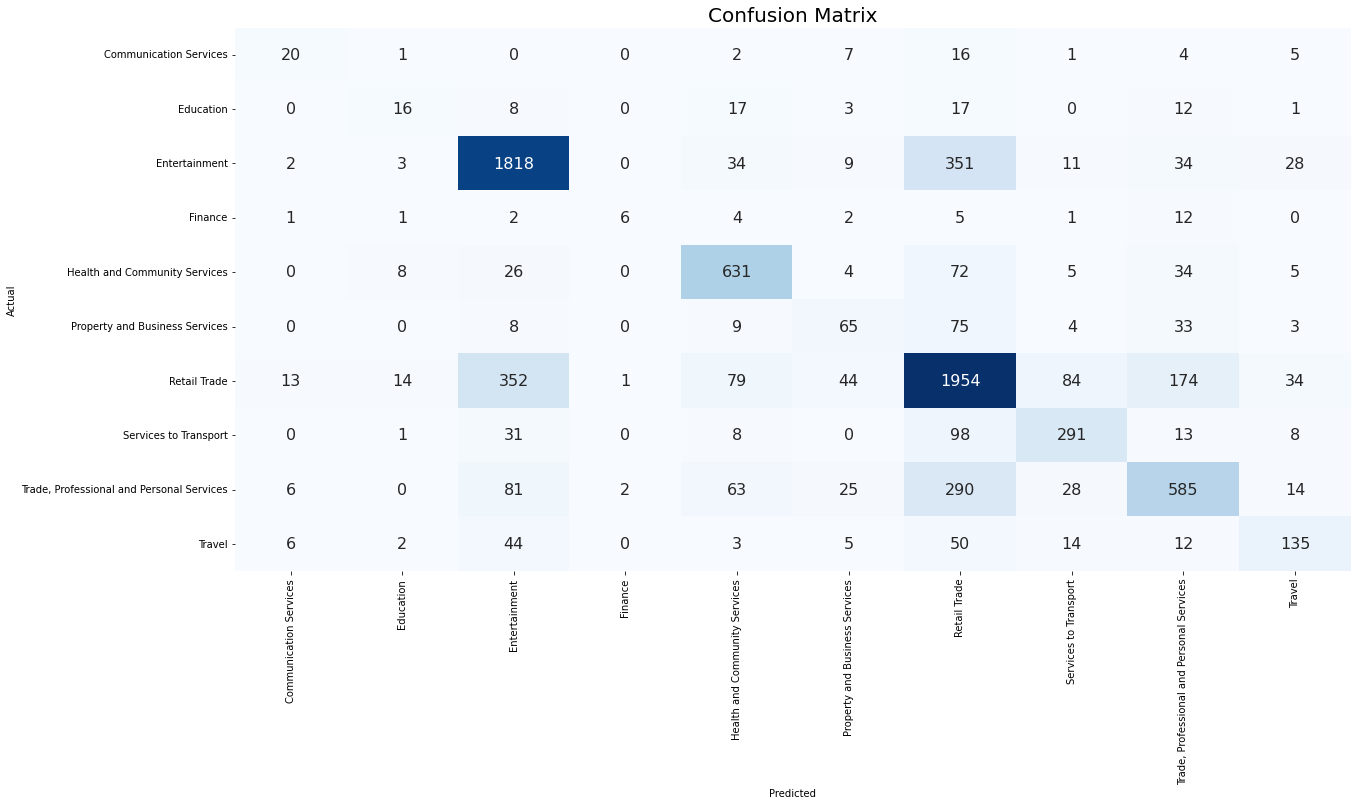

In [12]:
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Classification Report 

In [13]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.42      0.36      0.38        56
           1       0.35      0.22      0.27        74
           2       0.77      0.79      0.78      2290
           3       0.67      0.18      0.28        34
           4       0.74      0.80      0.77       785
           5       0.40      0.33      0.36       197
           6       0.67      0.71      0.69      2749
           7       0.66      0.65      0.65       450
           8       0.64      0.53      0.58      1094
           9       0.58      0.50      0.54       271

    accuracy                           0.69      8000
   macro avg       0.59      0.51      0.53      8000
weighted avg       0.69      0.69      0.69      8000



## Multiclass ROC-AUC Curve

ROC AUC score: 0.943946431423611


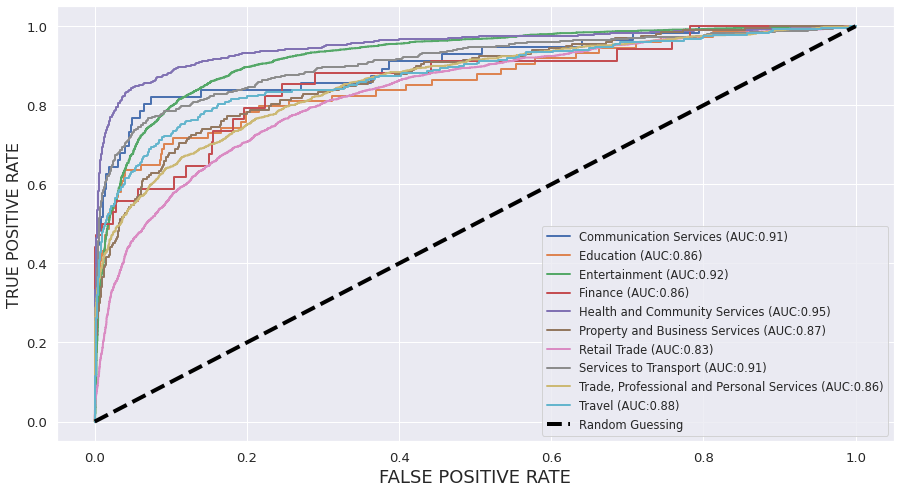

In [14]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show();

# Predictions on Test Set

In [15]:
test = pd.read_excel("/content/Test.xlsx")

test_dataset = Dataset.from_pandas(test[["trans_desc"]])
test_dataset = test_dataset.map(tokenize,remove_columns=['trans_desc'])


preds = trainer.predict(test_dataset)
preds = preds.predictions
test_preds = np.argmax(preds , axis = 1 )
test_preds = encoder.inverse_transform(test_preds)
test["Category"] = test_preds
test.to_excel("Submission.xlsx")

#The Test data is first loaded and processed in the same manner as the training data.
#Followed by processing, tokenization was done on the transaction description column. 
#The tokenized data was passed on to the trained model for predictions. 
#The predictions were then inverse transformed with the same encoder used for train data and replaced with the Category column of the test data. 
#At last, the test data was saved as an excel file.

  0%|          | 0/10000 [00:00<?, ?ex/s]

***** Running Prediction *****
  Num examples = 10000
  Batch size = 32
